In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt
from matplotlib import dates as md
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
from datetime import datetime

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Dense 
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import model_from_json

tf.__version__

'2.3.0'

In [58]:
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_FB.csv'
fb_df = pd.read_csv(url, error_bad_lines=False)
fb_df.head(5)

,timestamp,value
0,2015-02-26 21:42:53,53
1,2015-02-26 21:47:53,64
2,2015-02-26 21:52:53,49
3,2015-02-26 21:57:53,48
4,2015-02-26 22:02:53,22


In [59]:
fb_df.describe()

,value
count,15833.000000
mean,17.811280
std,19.740055
min,0.000000
25%,9.000000
50%,14.000000
75%,22.000000
max,1258.000000


# **AUTOENCODER MODEL 1 FOR ANOMALY DETECTION**

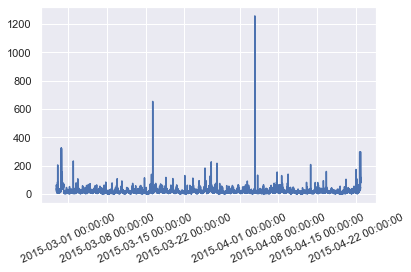

In [51]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

plot_dates_values(fb_df)

In [60]:
#fb_df.set_index('timestamp', inplace=True)
msk = np.random.rand(len(fb_df)) < 0.8
dataset_train = fb_df[msk]
dataset_test = fb_df[~msk]
print(len(dataset_test))
print(len(dataset_train))

3106
12727


In [61]:
fb_df['timestamp'].head()

0    2015-02-26 21:42:53
1    2015-02-26 21:47:53
2    2015-02-26 21:52:53
3    2015-02-26 21:57:53
4    2015-02-26 22:02:53
Name: timestamp, dtype: object

In [6]:
def get_value_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std



# Get the `value` column from the training abd  dataframe.
training_value = get_value_from_df(dataset_train)
testing_value = get_value_from_df(dataset_test)



# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
testing_value, testing_mean, testing_std = normalize(testing_value)

In [7]:
TIME_STEPS = 288


def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)


x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

x_test = create_sequences(testing_value)
print("Test input shape: ", x_test.shape)

Training input shape:  (12395, 288, 1)
Test input shape:  (2862, 288, 1)


In [8]:
model = Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [9]:
history=model.fit(np.array(x_train),np.array(x_train),
                  batch_size=128, 
                  epochs=100,
                  validation_split=0.1,
                  verbose = 1)

Epoch 1/100
88/88 [==============================] - 6s 66ms/step - loss: 0.4022 - val_loss: 0.0494
Epoch 2/100
88/88 [==============================] - 6s 66ms/step - loss: 0.0928 - val_loss: 0.0250
Epoch 3/100
88/88 [==============================] - 6s 69ms/step - loss: 0.0698 - val_loss: 0.0201
Epoch 4/100
88/88 [==============================] - 6s 65ms/step - loss: 0.0599 - val_loss: 0.0168
Epoch 5/100
88/88 [==============================] - 6s 65ms/step - loss: 0.0533 - val_loss: 0.0156
Epoch 6/100
88/88 [==============================] - 6s 68ms/step - loss: 0.0500 - val_loss: 0.0151
Epoch 7/100
88/88 [==============================] - 5s 59ms/step - loss: 0.0451 - val_loss: 0.0145
Epoch 8/100
88/88 [==============================] - 5s 55ms/step - loss: 0.0422 - val_loss: 0.0152
Epoch 9/100
88/88 [==============================] - 5s 54ms/step - loss: 0.0399 - val_loss: 0.0113
Epoch 10/100
88/88 [==============================] - 5s 57ms/step - loss: 0.0381 - val_loss: 0.0126

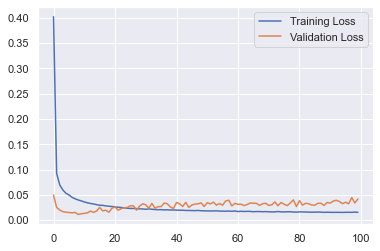

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

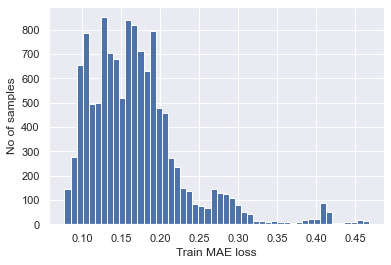

Reconstruction error threshold:  0.4672547361138401


In [11]:
# Train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

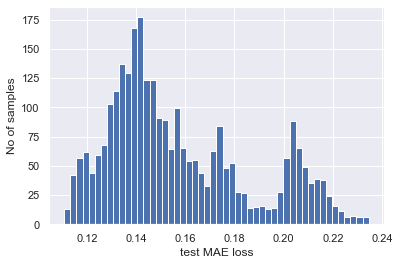

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


In [12]:
# Test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

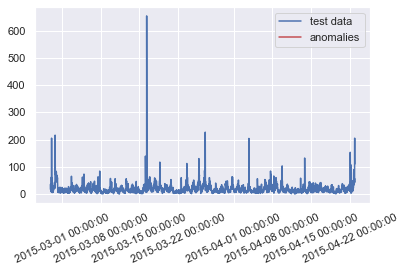

In [62]:
#Plot anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(testing_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

df_subset = dataset_test.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = dataset_test['timestamp'].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = dataset_test["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset['timestamp'].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()

# **AUTOENCODER MODEL 2 FOR ANOMALY DETECTION**

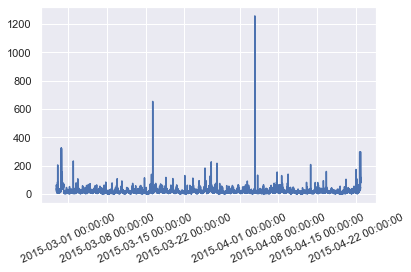

<Figure size 720x432 with 0 Axes>

In [63]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()
    plt.figure(figsize=(10,6))

plot_dates_values(fb_df)

In [64]:
fb_df.set_index('timestamp', inplace=True)
msk = np.random.rand(len(fb_df)) < 0.8
dataset_train = fb_df[msk]
dataset_test = fb_df[~msk]
print(len(dataset_test))
print(len(dataset_train))

3191
12642


In [65]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

In [66]:
seed(10)
tf.random.set_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

In [67]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Epoch 1/100
1201/1201 [==============================] - 1s 488us/step - loss: 3.2465e-05 - val_loss: 1.8428e-06
Epoch 2/100
1201/1201 [==============================] - 1s 432us/step - loss: 2.1880e-05 - val_loss: 1.1546e-05
Epoch 3/100
1201/1201 [==============================] - 1s 429us/step - loss: 1.4517e-05 - val_loss: 3.5023e-07
Epoch 4/100
1201/1201 [==============================] - 1s 431us/step - loss: 1.4679e-05 - val_loss: 3.7494e-06
Epoch 5/100
1201/1201 [==============================] - 1s 427us/step - loss: 1.1081e-05 - val_loss: 5.6710e-05
Epoch 6/100
1201/1201 [==============================] - 1s 493us/step - loss: 9.5339e-06 - val_loss: 5.6714e-06
Epoch 7/100
1201/1201 [==============================] - 1s 482us/step - loss: 5.1670e-06 - val_loss: 1.1546e-07
Epoch 8/100
1201/1201 [==============================] - 1s 461us/step - loss: 5.6372e-06 - val_loss: 1.2228e-07
Epoch 9/100
1201/1201 [==============================] - 1s 461us/step - loss: 5.1823e-06 - val_

Epoch 73/100
1201/1201 [==============================] - 1s 558us/step - loss: 4.3082e-07 - val_loss: 9.8752e-09
Epoch 74/100
1201/1201 [==============================] - 1s 492us/step - loss: 1.5258e-06 - val_loss: 1.1492e-08
Epoch 75/100
1201/1201 [==============================] - 1s 440us/step - loss: 2.1874e-07 - val_loss: 3.3196e-08
Epoch 76/100
1201/1201 [==============================] - 1s 498us/step - loss: 3.0595e-07 - val_loss: 7.3157e-09
Epoch 77/100
1201/1201 [==============================] - 1s 474us/step - loss: 4.4182e-07 - val_loss: 1.2649e-07
Epoch 78/100
1201/1201 [==============================] - 1s 464us/step - loss: 4.2050e-07 - val_loss: 3.6085e-08
Epoch 79/100
1201/1201 [==============================] - 1s 465us/step - loss: 2.1502e-07 - val_loss: 7.9739e-08
Epoch 80/100
1201/1201 [==============================] - 1s 447us/step - loss: 2.9000e-07 - val_loss: 1.1376e-08
Epoch 81/100
1201/1201 [==============================] - 1s 476us/step - loss: 2.5714e-

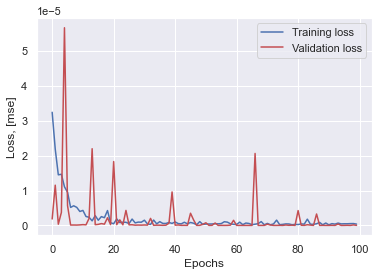

In [68]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

Reconstruction error threshold:  0.007825076580047607


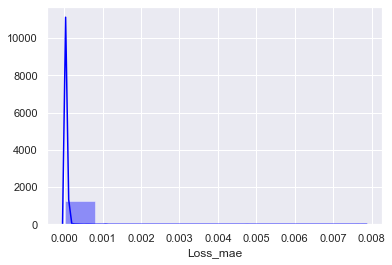

In [69]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');


# Get reconstruction loss threshold.
threshold = np.max(scored['Loss_mae'])
print("Reconstruction error threshold: ", threshold)

In [70]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.008
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
timestamp,,,
2015-02-26 21:42:53,0.000046,0.008,False
2015-02-26 21:57:53,0.000030,0.008,False
2015-02-26 22:07:53,0.000023,0.008,False
2015-02-26 22:32:53,0.000017,0.008,False
2015-02-26 22:37:53,0.000011,0.008,False


In [71]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.008
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='timestamp'>

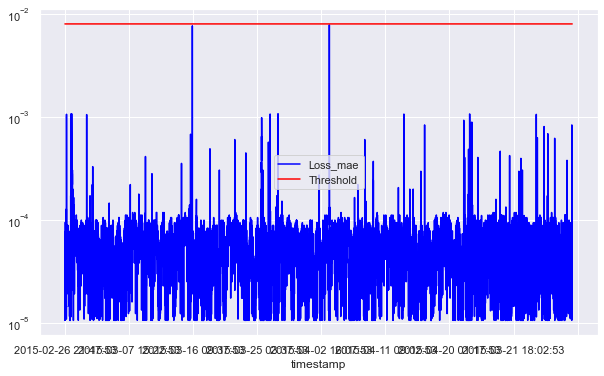

In [72]:
scored.plot(logy=True,  figsize = (10,6), color = ['blue','red'])

# **AUTOENCODER MODEL 3 FOR ANOMALY DETECTION**

In [73]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_train, y_train = create_dataset(
  dataset_train[['value']],
  dataset_train.value,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  dataset_test[['value']],
  dataset_test.value,
  TIME_STEPS
)

In [74]:
model = Sequential()
model.add(layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(layers.Dropout(rate=0.2))
model.add(layers.RepeatVector(n=X_train.shape[1]))
model.add(layers.LSTM(units=64, return_sequences=True))
model.add(layers.Dropout(rate=0.2))
model.add(layers.TimeDistributed(layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')

In [75]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
355/355 [==============================] - 8s 23ms/step - loss: 9.2491 - val_loss: 7.9311
Epoch 2/100
355/355 [==============================] - 7s 21ms/step - loss: 7.0721 - val_loss: 7.2142
Epoch 3/100
355/355 [==============================] - 7s 19ms/step - loss: 6.6543 - val_loss: 7.0370
Epoch 4/100
355/355 [==============================] - 8s 22ms/step - loss: 6.4832 - val_loss: 6.9106
Epoch 5/100
355/355 [==============================] - 7s 20ms/step - loss: 6.3617 - val_loss: 6.8086
Epoch 6/100
355/355 [==============================] - 8s 22ms/step - loss: 6.2559 - val_loss: 6.7107
Epoch 7/100
355/355 [==============================] - 8s 22ms/step - loss: 6.2015 - val_loss: 6.6823
Epoch 8/100
355/355 [==============================] - 8s 23ms/step - loss: 6.1417 - val_loss: 6.6572
Epoch 9/100
355/355 [==============================] - 7s 20ms/step - loss: 6.1016 - val_loss: 6.5933
Epoch 10/100
355/355 [==============================] - 8s 23ms/step - loss: 6.070

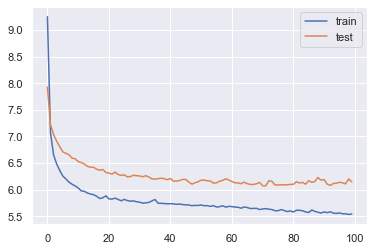

In [76]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

Reconstruction error threshold:  120.08054555257162


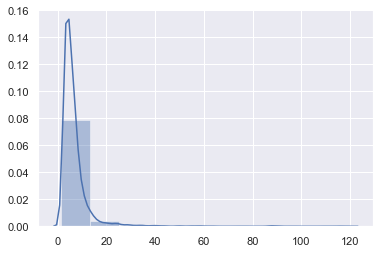

In [77]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
sns.distplot(train_mae_loss, bins=10, kde=True);

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  76.84957071940104


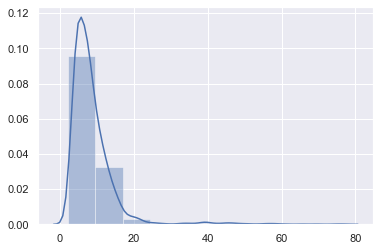

In [78]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
sns.distplot(test_mae_loss, bins=10, kde=True);

# Get reconstruction loss threshold.
threshold = np.max(test_mae_loss)
print("Reconstruction error threshold: ", threshold)

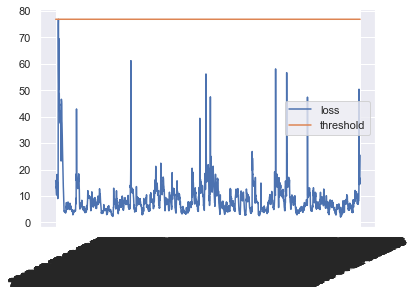

In [79]:
test_score_df = pd.DataFrame(index=dataset_test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['value'] = dataset_test[TIME_STEPS:].value

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [80]:
test_score_df.head()

,loss,threshold,anomaly,value
timestamp,,,,
2015-02-27 08:37:53,15.853208,76.849571,False,8
2015-02-27 09:32:53,15.162378,76.849571,False,16
2015-02-27 09:37:53,13.134840,76.849571,False,10
2015-02-27 09:42:53,13.514755,76.849571,False,8
2015-02-27 10:27:53,13.224740,76.849571,False,11


## Previously used models for conv1d model

#### Adam optimizer. Learning rate = .01. Batch = 64

In [81]:
model_v1 = Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model_v1.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss="mse")
model_v1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_5 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 288, 1)           

In [82]:
history=model_v1.fit(np.array(x_train),np.array(x_train),
                  batch_size=64, 
                  epochs=100,
                  validation_split=0.1,
                  verbose = 1)

Epoch 1/100
175/175 [==============================] - 6s 33ms/step - loss: 0.2417 - val_loss: 0.0312
Epoch 2/100
175/175 [==============================] - 5s 29ms/step - loss: 0.0604 - val_loss: 0.0254
Epoch 3/100
175/175 [==============================] - 5s 30ms/step - loss: 0.0445 - val_loss: 0.0301
Epoch 4/100
175/175 [==============================] - 5s 29ms/step - loss: 0.0394 - val_loss: 0.0228
Epoch 5/100
175/175 [==============================] - 6s 32ms/step - loss: 0.0333 - val_loss: 0.0318
Epoch 6/100
175/175 [==============================] - 5s 29ms/step - loss: 0.0305 - val_loss: 0.0283
Epoch 7/100
175/175 [==============================] - 5s 29ms/step - loss: 0.0299 - val_loss: 0.0202
Epoch 8/100
175/175 [==============================] - 6s 31ms/step - loss: 0.0298 - val_loss: 0.0452
Epoch 9/100
175/175 [==============================] - 5s 28ms/step - loss: 0.0275 - val_loss: 0.0226
Epoch 10/100
175/175 [==============================] - 6s 34ms/step - loss: 0.026

### SGD optimizer, lr = .001, batch = 32 

In [84]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.001, momentum=0.9)


In [85]:
model_v2 = Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model_v2.compile(optimizer=opt, loss="mse")
model_v2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_7 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 288, 1)           

In [86]:
history=model_v2.fit(np.array(x_train),np.array(x_train),
                  batch_size=32, 
                  epochs=100,
                  validation_split=0.1,
                  verbose = 1)

Epoch 1/100
349/349 [==============================] - 7s 19ms/step - loss: 0.6159 - val_loss: 0.2458
Epoch 2/100
349/349 [==============================] - 7s 20ms/step - loss: 0.4276 - val_loss: 0.1770
Epoch 3/100
349/349 [==============================] - 7s 19ms/step - loss: 0.3501 - val_loss: 0.1243
Epoch 4/100
349/349 [==============================] - 7s 19ms/step - loss: 0.2807 - val_loss: 0.0940
Epoch 5/100
349/349 [==============================] - 7s 19ms/step - loss: 0.2215 - val_loss: 0.0677
Epoch 6/100
349/349 [==============================] - 6s 17ms/step - loss: 0.1640 - val_loss: 0.0473
Epoch 7/100
349/349 [==============================] - 6s 18ms/step - loss: 0.1325 - val_loss: 0.0394
Epoch 8/100
349/349 [==============================] - 7s 20ms/step - loss: 0.1193 - val_loss: 0.0367
Epoch 9/100
349/349 [==============================] - 7s 19ms/step - loss: 0.1106 - val_loss: 0.0340
Epoch 10/100
349/349 [==============================] - 7s 20ms/step - loss: 0.106